# N-BaIoT Dataset Analysis with PyTorch Neural Network

This notebook implements a Multi-Layer Perceptron (MLP) model for analyzing and classifying network traffic from the N-BaIoT dataset, focusing on five specific attack classes.

## Configuration Settings
The following cell contains all the hyperparameters and configuration settings that can be easily modified.

In [65]:
# ========================== CONFIGURATION PARAMETERS ==========================
# You can modify these parameters to change the behavior of the model

# 1. Data Loading Parameters
DATA_PATH = "../../MegaProject/fdata"        # Path to the dataset
DEVICES = [1, 2, 4,5,6]                          # Devices to load data from
SAMPLES_PER_CLASS = 15000                     # Reduced samples per class to keep total under 120,000

# 2. Selected Classes (focusing on 5 classes as requested)
SELECTED_CLASSES = {
    'benign': 0,              # Benign traffic
    'mirai.syn': 1,           # Mirai SYN attack
    'mirai.scan': 2,          # Mirai Scan attack
    'gafgyt.junk': 3,         # Gafgyt Junk attack
    'gafgyt.udp': 4           # Gafgyt UDP attack
}

# 3. Feature Selection - Keep the 25 most important features
TOP_FEATURES = [
    'HH_L1_weight', 'HH_jit_L1_weight', 'MI_dir_L0.01_mean', 'H_L0.1_weight', 'H_L0.1_mean',
    'MI_dir_L1_mean', 'H_L1_mean', 'H_L0.01_variance', 'MI_dir_L0.01_variance', 'H_L5_weight',
    'H_L0.1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L5_weight', 'H_L0.01_mean',
    'H_L5_mean', 'MI_dir_L0.1_variance', 'MI_dir_L3_mean', 'MI_dir_L5_mean', 'HH_jit_L5_mean',
    'HH_jit_L3_mean', 'H_L3_mean', 'HH_L3_magnitude', 'MI_dir_L3_weight', 'HpHp_L0.01_weight'
]

# 4. Model Hyperparameters
HIDDEN_LAYERS = 3             # Number of hidden layers in the MLP
NEURONS_PER_LAYER = 21       # Neurons in each hidden layer
LEARNING_RATE = 0.001         # Learning rate for Adam optimizer
BATCH_SIZE = 64               # Batch size for training
NUM_EPOCHS = 8           # Number of training epochs
DROPOUT_RATE = 0.3            # Dropout rate for regularization

# 5. Training Parameters
TEST_SIZE = 0.3               # Proportion of data to use for testing
RANDOM_SEED = 42              # Random seed for reproducibility

# Project Setup

Let's set up the project by importing necessary libraries, checking device availability, and implementing our data loading functions for the five specific classes from the N-BaIoT dataset.

In [66]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set plotting style
plt.style.use('seaborn-v0_8')

# Device configuration - use GPU if available, otherwise CPU
device = "cuda" 
print(f"Using device: {device}")

Using device: cuda


# Data Loading and Preprocessing

We'll focus on loading five specific classes from the N-BaIoT dataset:
1. Benign traffic (normal traffic)
2. Mirai SYN attack
3. Mirai Scan attack
4. Gafgyt Junk attack
5. Gafgyt UDP attack

For each class, we'll load up to the specified number of samples (configured in the parameters section).

In [67]:
def load_selected_data(data_path, selected_classes, devices, samples_per_class=15000):
    """
    Load and preprocess data from the N-BaIoT dataset, focusing only on selected classes.
    
    Args:
        data_path: Path to the dataset files
        selected_classes: Dictionary mapping class names to their numeric labels
        devices: List of device numbers to load data from
        samples_per_class: Maximum number of samples to load per class
    
    Returns:
        Dataframe containing the blended dataset with selected classes
    """
    # Mapping from class name to file pattern
    class_to_file = {
        'benign': 'benign.csv',
        'mirai.syn': 'mirai.syn.csv',
        'mirai.scan': 'mirai.scan.csv',
        'gafgyt.junk': 'gafgyt.junk.csv',
        'gafgyt.udp': 'gafgyt.udp.csv'
    }
    
    print(f"Loading data from {len(devices)} devices for {len(selected_classes)} classes...")
    print(f"Selected classes: {', '.join(selected_classes.keys())}")
    print(f"Samples per class: {samples_per_class}")
    
    # Generate file list for specified devices and classes
    files_to_load = []
    for device in devices:
        for class_name, label in selected_classes.items():
            filename = f'{device}.{class_to_file[class_name]}'
            file_path = os.path.join(data_path, filename)
            if os.path.exists(file_path):
                files_to_load.append((file_path, filename, class_name, label))
            else:
                print(f"File not found: {filename}")
    
    print(f"Found {len(files_to_load)} files to process")
    
    # Load and process each file
    dataframes = []
    class_samples = defaultdict(int)
    
    for file_path, filename, class_name, label in files_to_load:
        print(f"Processing {filename}...")
        
        # Read CSV file
        df = pd.read_csv(file_path)
        
        # Assign label
        df['label'] = label
        
        # Sample if needed
        if samples_per_class and len(df) > samples_per_class:
            # Check how many samples we already have for this class
            remaining = max(0, samples_per_class - class_samples[class_name])
            if remaining > 0:
                df = df.sample(min(remaining, len(df)), random_state=RANDOM_SEED)
                class_samples[class_name] += len(df)
                print(f"  Added {len(df)} samples with label {label} ({class_name})")
                dataframes.append(df)
            else:
                print(f"  Skipped - already have {samples_per_class} samples for {class_name}")
        else:
            class_samples[class_name] += len(df)
            print(f"  Added {len(df)} samples with label {label} ({class_name})")
            dataframes.append(df)
    
    # Combine all data
    if dataframes:
        blended_data = pd.concat(dataframes, ignore_index=True)
        print(f"\nFinal dataset shape: {blended_data.shape}")
        print(f"Total samples per class:")
        for class_name, count in class_samples.items():
            label = selected_classes[class_name]
            print(f"  {class_name} (Label {label}): {count} samples")
        return blended_data
    else:
        print("No data was loaded!")
        return None

# Load the selected data using our configuration parameters
blended_data = load_selected_data(
    data_path=DATA_PATH, 
    selected_classes=SELECTED_CLASSES,
    devices=DEVICES,
    samples_per_class=SAMPLES_PER_CLASS
)

Loading data from 5 devices for 5 classes...
Selected classes: benign, mirai.syn, mirai.scan, gafgyt.junk, gafgyt.udp
Samples per class: 15000
Found 25 files to process
Processing 1.benign.csv...
  Added 15000 samples with label 0 (benign)
Processing 1.mirai.syn.csv...
  Added 15000 samples with label 1 (mirai.syn)
Processing 1.mirai.scan.csv...
  Added 15000 samples with label 2 (mirai.scan)
Processing 1.gafgyt.junk.csv...
  Added 15000 samples with label 3 (gafgyt.junk)
Processing 1.gafgyt.udp.csv...
  Added 15000 samples with label 4 (gafgyt.udp)
Processing 2.benign.csv...
  Added 13113 samples with label 0 (benign)
Processing 2.mirai.syn.csv...
  Skipped - already have 15000 samples for mirai.syn
Processing 2.mirai.scan.csv...
  Skipped - already have 15000 samples for mirai.scan
Processing 2.gafgyt.junk.csv...
  Skipped - already have 15000 samples for gafgyt.junk
Processing 2.gafgyt.udp.csv...
  Skipped - already have 15000 samples for gafgyt.udp
Processing 4.benign.csv...
  Skip

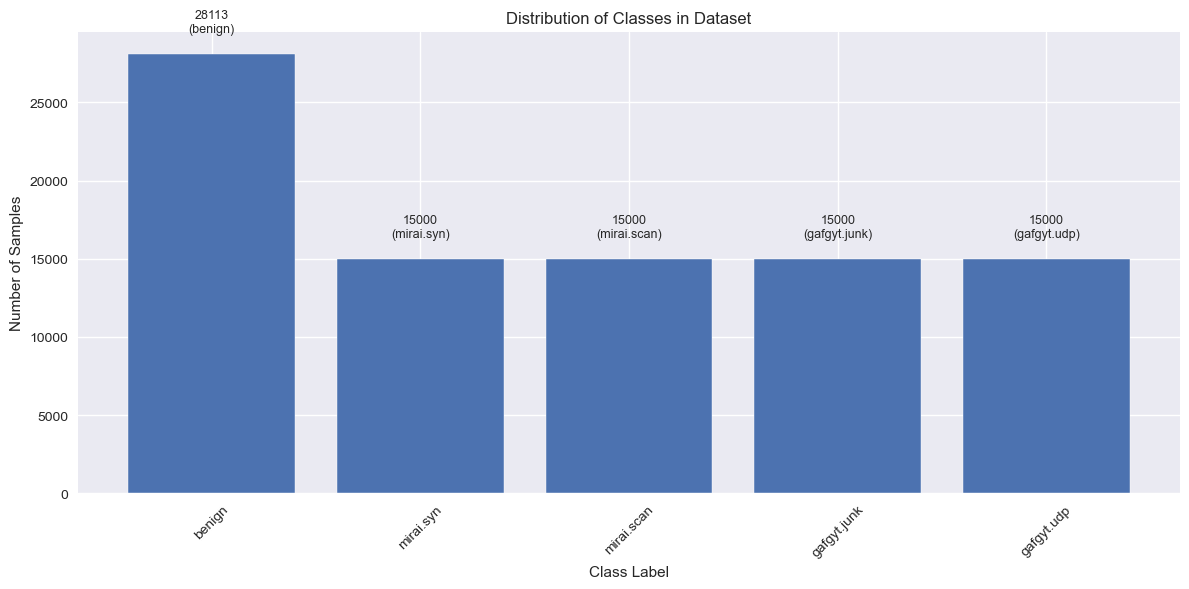

In [68]:
# Visualize the class distribution
if 'blended_data' in locals() and not blended_data.empty and 'label' in blended_data.columns:
    # Create a reverse mapping from label to class name
    label_to_class = {v: k for k, v in SELECTED_CLASSES.items()}
    
    # Plot label distribution
    plt.figure(figsize=(12, 6))
    counts = blended_data['label'].value_counts().sort_index()
    bars = plt.bar(range(len(counts)), counts.values)
    
    # Add labels to the bars
    for i, count in enumerate(counts):
        label_value = counts.index[i]
        class_name = label_to_class.get(label_value, f'Unknown_{label_value}')
        plt.text(i, count + 0.05*max(counts.values), 
                 f"{count}\n({class_name})", 
                 ha='center', fontsize=9)
    
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Classes in Dataset')
    plt.xticks(range(len(counts)), [label_to_class.get(l, f'Unknown_{l}') for l in counts.index], rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Failed to load data. Please check the path and file structure.")

# Feature Selection and Preprocessing

We'll select the top 25 features specified in our configuration and preprocess the data for model training:
1. Select only numeric features
2. Keep only the specified most important features
3. Standardize the features
4. Split into training and testing sets

In [69]:
def preprocess_data(data, top_features, test_size=0.2, random_seed=42):
    """
    Preprocess the dataset by selecting features and standardizing
    
    Args:
        data: DataFrame containing the dataset
        top_features: List of feature names to select
        test_size: Proportion of data for testing
        random_seed: Random seed for reproducibility
    
    Returns:
        X_train, X_test, y_train, y_test: Processed data splits
        feature_names: Names of selected features
    """
    if data is None or data.empty:
        print("No data to preprocess!")
        return None, None, None, None, None
    
    print("Preprocessing data...")
    
    # 1. Drop any non-numeric columns (except label)
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if 'label' not in numeric_cols and 'label' in data.columns:
        numeric_cols.append('label')
    
    data = data[numeric_cols]
    
    # 2. Split features and target
    X = data.drop('label', axis=1)
    y = data['label']
    
    # Get all available features
    available_features = X.columns.tolist()
    print(f"Total available features: {len(available_features)}")
    
    # 3. Select specified top features
    valid_features = [f for f in top_features if f in available_features]
    
    if len(valid_features) < len(top_features):
        print(f"Warning: {len(top_features) - len(valid_features)} specified features not found in dataset")
        print(f"Using {len(valid_features)} valid features from the specified list")
        
        if len(valid_features) == 0:
            print("No valid features found! Using all available features instead.")
            valid_features = available_features[:25]  # Use the first 25 if none match
    
    print(f"Selected {len(valid_features)} features")
    X_selected = X[valid_features]
    
    # 4. Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # 5. Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_seed, stratify=y)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, valid_features

# Preprocess the data
X_train, X_test, y_train, y_test, selected_features = preprocess_data(
    data=blended_data,
    top_features=TOP_FEATURES,
    test_size=TEST_SIZE,
    random_seed=RANDOM_SEED
)

# Display the selected features
if selected_features:
    print("\nSelected Features:")
    for i, feature in enumerate(selected_features):
        print(f"{i+1}. {feature}")

# Check class distribution in the training and test sets
if 'y_train' in locals() and 'y_test' in locals():
    print("\nClass distribution in train set:")
    train_counts = pd.Series(y_train).value_counts().sort_index()
    for label, count in train_counts.items():
        class_name = next((k for k, v in SELECTED_CLASSES.items() if v == label), f'Unknown_{label}')
        print(f"  Class {label} ({class_name}): {count} samples")
        
    print("\nClass distribution in test set:")
    test_counts = pd.Series(y_test).value_counts().sort_index()
    for label, count in test_counts.items():
        class_name = next((k for k, v in SELECTED_CLASSES.items() if v == label), f'Unknown_{label}')
        print(f"  Class {label} ({class_name}): {count} samples")

Preprocessing data...
Total available features: 115
Selected 25 features
Training data shape: (61679, 25)
Testing data shape: (26434, 25)

Selected Features:
1. HH_L1_weight
2. HH_jit_L1_weight
3. MI_dir_L0.01_mean
4. H_L0.1_weight
5. H_L0.1_mean
6. MI_dir_L1_mean
7. H_L1_mean
8. H_L0.01_variance
9. MI_dir_L0.01_variance
10. H_L5_weight
11. H_L0.1_variance
12. MI_dir_L0.1_weight
13. MI_dir_L0.1_mean
14. MI_dir_L5_weight
15. H_L0.01_mean
16. H_L5_mean
17. MI_dir_L0.1_variance
18. MI_dir_L3_mean
19. MI_dir_L5_mean
20. HH_jit_L5_mean
21. HH_jit_L3_mean
22. H_L3_mean
23. HH_L3_magnitude
24. MI_dir_L3_weight
25. HpHp_L0.01_weight

Class distribution in train set:
  Class 0 (benign): 19679 samples
  Class 1 (mirai.syn): 10500 samples
  Class 2 (mirai.scan): 10500 samples
  Class 3 (gafgyt.junk): 10500 samples
  Class 4 (gafgyt.udp): 10500 samples

Class distribution in test set:
  Class 0 (benign): 8434 samples
  Class 1 (mirai.syn): 4500 samples
  Class 2 (mirai.scan): 4500 samples
  Class 

# Neural Network Model Architecture

Here, we'll define a multi-layer perceptron (MLP) model with the specified architecture:
- 4 hidden layers
- 32 neurons per hidden layer
- ReLU activation functions
- Softmax output layer
- Dropout for regularization

In [70]:
class NBaIoTMLP(nn.Module):
    """
    Multi-layer perceptron for N-BaIoT dataset classification

    Implements a neural network with:
    - Configurable number of hidden layers
    - Configurable number of neurons per layer
    - ReLU activations
    - Batch normalization for faster, more stable training
    - Dropout for regularization
    - Softmax output for multi-class classification (apply externally during inference)
    """
    def __init__(self, input_dim, num_classes, hidden_layers=4, neurons_per_layer=32, dropout_rate=0.2):
        super(NBaIoTMLP, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, neurons_per_layer))
        layers.append(nn.BatchNorm1d(neurons_per_layer))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(neurons_per_layer, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.layers(x)
        return logits  # Return raw logits (softmax handled by CrossEntropyLoss)
        

# Convert preprocessed data to PyTorch tensors
if 'X_train' in locals() and X_train is not None:
    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Number of batches in train_loader: {len(train_loader)}")
    print(f"Number of batches in test_loader: {len(test_loader)}")

    # Create the MLP model
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    model = NBaIoTMLP(
        input_dim=input_dim, 
        num_classes=num_classes,
        hidden_layers=HIDDEN_LAYERS,
        neurons_per_layer=NEURONS_PER_LAYER,
        dropout_rate=DROPOUT_RATE
    )

    # Move model to device (GPU if available)
    model.to(device)
    print(f"\nModel created and moved to {device}")
    print(model)
else:
    print("Please run the data preprocessing cells first.")


Number of batches in train_loader: 964
Number of batches in test_loader: 414

Model created and moved to cuda
NBaIoTMLP(
  (layers): Sequential(
    (0): Linear(in_features=25, out_features=21, bias=True)
    (1): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=21, out_features=21, bias=True)
    (5): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=21, out_features=21, bias=True)
    (9): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=21, out_features=5, bias=True)
  )
)


# Model Training and Evaluation

We'll train the model using:
- Adam optimizer with configurable learning rate
- Cross-entropy loss function
- Learning rate scheduler to reduce LR when validation loss plateaus
- Early stopping to prevent overfitting

In [71]:
# Define training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Define evaluation function
def evaluate(model, data_loader, criterion, device):
    """Evaluate the model on validation or test data"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Set up training parameters
if 'model' in locals():
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    print(f"Training parameters set up:")
    print(f"- Optimizer: Adam with learning rate: {LEARNING_RATE}")
    print(f"- Loss function: CrossEntropyLoss")
    print(f"- Batch size: {BATCH_SIZE}")
    print(f"- Number of epochs: {NUM_EPOCHS}")
else:
    print("Please run the previous cell to create the model first.")

Training parameters set up:
- Optimizer: Adam with learning rate: 0.001
- Loss function: CrossEntropyLoss
- Batch size: 64
- Number of epochs: 8


In [72]:
# Train the model
if 'model' in locals() and 'train_loader' in locals():
    # Lists to store metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    # Get the device
    device = next(model.parameters()).device
    
    print(f"Starting training for {NUM_EPOCHS} epochs...")
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Evaluate
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print metrics
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    print("Training complete!")
    
    # Final evaluation on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Save the model
    torch.save(model.state_dict(), 'nbaiot_model.pth')
    print("Model saved as 'nbaiot_model.pth'")
else:
    print("Please run the previous cells to create the model and data loaders first.")

Starting training for 8 epochs...
Epoch 1/8, Train Loss: 0.4228, Train Acc: 0.8710, Val Loss: 0.0536, Val Acc: 0.9879
Epoch 2/8, Train Loss: 0.1486, Train Acc: 0.9597, Val Loss: 0.0463, Val Acc: 0.9879
Epoch 3/8, Train Loss: 0.1196, Train Acc: 0.9680, Val Loss: 0.0445, Val Acc: 0.9885
Epoch 4/8, Train Loss: 0.1065, Train Acc: 0.9711, Val Loss: 0.0429, Val Acc: 0.9887
Epoch 5/8, Train Loss: 0.0971, Train Acc: 0.9731, Val Loss: 0.0359, Val Acc: 0.9896
Epoch 6/8, Train Loss: 0.0865, Train Acc: 0.9754, Val Loss: 0.0310, Val Acc: 0.9899
Epoch 7/8, Train Loss: 0.0845, Train Acc: 0.9760, Val Loss: 0.0297, Val Acc: 0.9897
Epoch 8/8, Train Loss: 0.0793, Train Acc: 0.9769, Val Loss: 0.0224, Val Acc: 0.9939
Training complete!
Final Test Loss: 0.0224, Test Accuracy: 0.9939
Model saved as 'nbaiot_model.pth'


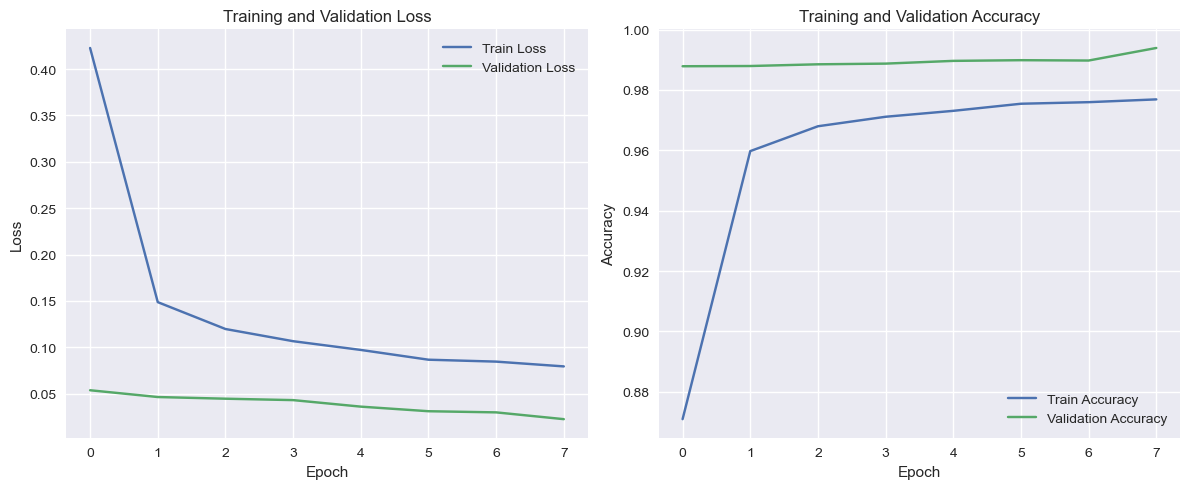

In [73]:
# Plot training history
if 'train_losses' in locals() and len(train_losses) > 0:
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()
else:
    print("Please run the training process first to generate training history.")

# Model Performance Analysis

Below, we'll analyze the model's performance by generating a confusion matrix and classification report.

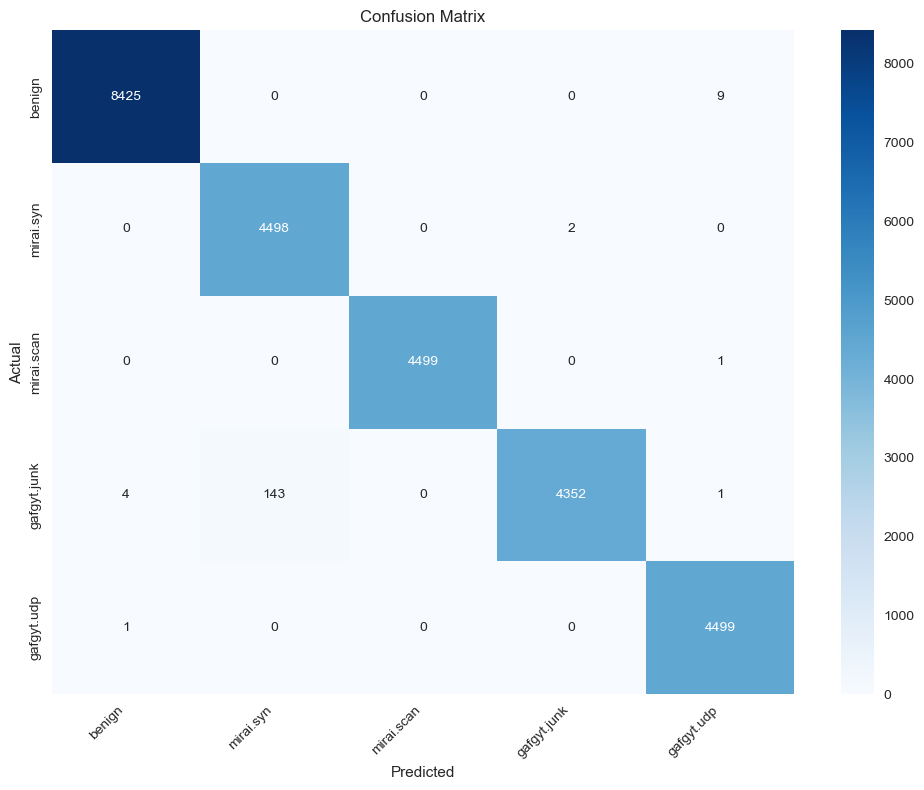

Classification Report:
              precision    recall  f1-score   support

      benign     0.9994    0.9989    0.9992      8434
   mirai.syn     0.9692    0.9996    0.9841      4500
  mirai.scan     1.0000    0.9998    0.9999      4500
 gafgyt.junk     0.9995    0.9671    0.9831      4500
  gafgyt.udp     0.9976    0.9998    0.9987      4500

    accuracy                         0.9939     26434
   macro avg     0.9931    0.9930    0.9930     26434
weighted avg     0.9941    0.9939    0.9939     26434


Per-class accuracy:
benign: 0.9989
mirai.syn: 0.9996
mirai.scan: 0.9998
gafgyt.junk: 0.9671
gafgyt.udp: 0.9998

Mean per-class accuracy: 0.9930


In [74]:
# Evaluate model performance with confusion matrix
if 'model' in locals() and 'test_loader' in locals():
    # Create class name mapping
    label_to_class = {v: k for k, v in SELECTED_CLASSES.items()}
    
    # Collect all predictions and actual labels
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Apply softmax to convert logits to probabilities for prediction
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Get class labels
    all_classes = sorted(np.unique(np.concatenate([all_labels, all_preds])))
    class_labels = [label_to_class.get(i, f'Unknown_{i}') for i in all_classes]
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    report = classification_report(all_labels, all_preds,
                                  target_names=class_labels,
                                  digits=4)
    print("Classification Report:")
    print(report)
    
    # Calculate per-class accuracy
    print("\nPer-class accuracy:")
    for i in range(len(all_classes)):
        class_acc = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0
        print(f"{class_labels[i]}: {class_acc:.4f}")
    
    # Calculate mean per-class accuracy
    mean_class_acc = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(len(all_classes)) if np.sum(cm[i, :]) > 0])
    print(f"\nMean per-class accuracy: {mean_class_acc:.4f}")
else:
    print("Please run the training cells first.")